In [1]:
from glob import glob 
import os 
from utils_tbox.utils_tbox import read_pklz
import pandas as pd
import lightning
from parse import parse
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from parse import parse
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def read_fun(fname):
    try:
        out = read_pklz(fname)
    except:
        out = None
    return out

def read_ours(all_exp_name, root_dir, thescore, our_best=False):
    lightning_logs_dir = os.path.join(root_dir)

    all_dfours = []
    for exp_name in all_exp_name:
        results_files = glob(os.path.join(lightning_logs_dir, exp_name, "**","*.pklz"))
        #print(results_files)
        all_results = list(map(read_fun, results_files))

        if isinstance(all_results[0], list):
            # ONLY KEEP THE MEANs
            all_results = [ll[0] for ll in all_results]
        #print(exp_name)
        if "DMS" in exp_name:
            score_suffix="/latent"
        else:
            score_suffix = ""
            
        the_scores = sum(list(map(partial(get_score_fname, thescore=thescore,score_suffix=score_suffix), all_results)),[])
        #print(the_scores)
        all_dfours.append(pd.DataFrame(data=np.array(the_scores), 
                                       columns=["DMS ID", exp_name]).sort_values("DMS ID").set_index("DMS ID").astype(float)
                         )
    dfours = pd.concat(all_dfours, axis=1)
    if our_best:
        dfours=dfours.max(1)
        dfours.name = "Our best"
        dfours = dfours.to_frame()
    return dfours

def get_score_fname(ll, thescore="",score_suffix=""):
    #print(ll)
    
    the_chkpt_keys = [k for k in ll.keys() if (k.startswith("lightning_logs") or (k==""))]
    if len(the_chkpt_keys)==0:
        thedict = ll#pass#print(ll)
    else:
        the_chkpt_key = the_chkpt_keys[0]
        thedict = ll[the_chkpt_key][0]
    
    the_score_keys = [k for k in thedict.keys() if parse(thescore+"/{}.csv"+score_suffix,k)]
    #print(thedict.keys())
    fnames = [parse(thescore+"/dms_{}.csv"+score_suffix, the_score_key)[0] for the_score_key in the_score_keys]
    return [[fname, float(thedict[the_score_key])] for fname, the_score_key in zip(fnames,the_score_keys)]

def read_benchmark(thescore, comparison_methods, all_exp_name, root_dir, our_best=False):
    substitution_benchmark = "../../ProteinGym/benchmarks/DMS_zero_shot/substitutions"

    if thescore == "spearmanr":
        fname = os.path.join(substitution_benchmark,"Spearman","DMS_substitutions_Spearman_DMS_level.csv")
    
    elif thescore == "auroc":
        fname = os.path.join(substitution_benchmark,"AUC","DMS_substitutions_AUC_DMS_level.csv")
    
    df = pd.read_csv(fname)
    df = df.set_index("DMS ID").drop(columns=['Number of Mutants', 'Selection Type', 'UniProt ID', 'MSA_Neff_L_category', 'Taxon'])
    
    comparison_methods_dict = {k.replace("{}","").strip(): 
                                   [s for s in df.columns if s.startswith(k) or parse(k,s)] 
                               for k in comparison_methods}
    # Find Best benchmark model
    all_models = np.array(df.columns)
    all_scores_data = df.values
    best_method_index = all_scores_data.argmax(1)
    best_method_score = all_scores_data.max(1)
    
    dfout = pd.DataFrame(index=df.index)

    # Get the best performing model flavor per model families in ProteinGym
    for agg_score, indiv_scores in comparison_methods_dict.items():
        dfout[agg_score] = df[indiv_scores].max(1)    
    
    dfout["Best Benchmark Name"] = all_models[best_method_index]
    dfout["Best Benchmark"] = best_method_score
    dfours = read_ours(all_exp_name, root_dir, thescore if thescore=="spearmanr" else "binary_" + thescore, our_best=our_best)
    dfout = pd.concat([dfout, dfours], axis=1).sort_values("Best Benchmark", ascending=True)
    return dfout, all_models, df, dfours

def plot_against_benchmark(dfout, plot_models,models_color,models_markers,thesize,figsize=(8,43),legend_loc=(-0.4,1.02),prefix="",thescore=""):
    the_minimum_score=np.nanmin(dfout[["Best Benchmark"]+plot_models].astype(float).values)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(dfout["Best Benchmark"], dfout.index,color="black",label="ProteinGym Best",marker="x",s=thesize)
    
    x_dashed_lines = np.concatenate([np.zeros((len(dfout.index),1))+the_minimum_score, dfout["Best Benchmark"].values.reshape(-1,1)],axis=1)
    y_dashed_lines= np.concatenate([dfout.index.values.reshape(-1,1), dfout.index.values.reshape(-1,1)],axis=1)
    for xx, yy in zip(x_dashed_lines, y_dashed_lines):
        ax.plot(xx, yy, linestyle=":", color="gray", alpha=0.4, zorder=-12)
    
    for modelname in plot_models:
        ax.scatter(dfout[modelname], dfout.index, label=modelname, color=models_color[modelname], s=thesize, marker=models_markers[modelname])
    
    score_label = {"spearmanr": "Spearman Rank Correlation Coefficient",
                   "auroc": "AUROC"}
                 
    ax.set_xlabel(prefix + "\n{}".format(score_label[thescore]))
    ax.set_ylabel("Protein-Deep Mutational Scanning dataset ($n={}$)".format(dfout.shape[0]))
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_ylim(-0.5, len(dfout.index)-0.5)
    ax.legend(loc=legend_loc, ncol=7)
    ax.grid(True, "major", "x", linestyle="--", linewidth=1, alpha=0.5, zorder=-13)
    return fig, ax

def make_table(dfout, all_compared_models, outname_stem, ref_model="minEVE",prefix="", save=False):
    minus_scores = -dfout[all_compared_models].astype(float).values
    topk_ind = np.argsort(minus_scores,axis=1)
    num2ord = {**{1:"$1^{st}$",2:"$2^{nd}$",3:"$3^{rd}$"},**{i:"$" +str(i)+"^{th}$"for i in range(4,20)}}

    df_topk = pd.DataFrame(index=dfout.index,
                           columns=[num2ord[i] for i in range(1,len(all_compared_models)+1)],
                           data=all_compared_models[topk_ind]
                          )
    df_topk_counts = df_topk.apply(pd.Series.value_counts).fillna(0).astype(int)
    
    ndigits = 3
    df_average_score = dfout[all_compared_models].mean().round(ndigits).apply(str) + " $\pm$ " + dfout[all_compared_models].std().round(ndigits).apply(str)
    df_average_score.name = "Average Raw"
    df_relative_score=pd.DataFrame()
    if not (ref_model is None):
        df_relative_score = ((dfout[all_compared_models]-dfout[[ref_model]].values)/dfout[[ref_model]].values).mean(0)#.round(ndigits)
        df_relative_score.name = "Average Relative"
        
    df_topk_average = pd.concat([df_topk_counts,df_average_score,df_relative_score],axis=1)
    df_topk_average.index.name=prefix
    df_topk_average = df_topk_average.sort_values("Average Raw",ascending=False)
    if save:
        df_topk_average.to_latex(outname_stem + ".tex", float_format="%.3f")
    return df_topk_average

possible_colors=["darkblue", "darkgreen","goldenrod","darkred","silver","tab:purple","tab:brown","tab:gray","peru","indigo", "darkorange","limegreen", "cadetblue"]
possible_markers=["<",">","^","d","s","h","P","p","o","D","1","+","2","3"] 

In [3]:
groups_fname = os.path.join("..","data","DMS_substitutions_groups.csv")
extra_cols = ["annotation","taxon","UniProt_ID", "seq_len",
                "MSA_start", "MSA_end", "MSA_len", 
                "MSA_bitscore",	"MSA_theta", "MSA_num_seqs", "MSA_perc_cov", 
                "MSA_num_cov",	"MSA_N_eff", "MSA_Neff_L",
                "Expected_SNVs",	"Observed_SNVs", "pLI", "oe","coarse_selection_type"]

groupnames = pd.read_csv(groups_fname)[["DMS_id"]+extra_cols].set_index("DMS_id")

groupnames["annotation"].replace({"other": "other human"},inplace=True)
groupnames["annotation"][groupnames["annotation"].isna()] = groupnames["taxon"][groupnames["annotation"].isna()]
groupnames["annotation"].unique()
interest_groups = ['drug target', 'ADME-CYP', 'ADME-other', 'ADME-transporter', "other human"]
groupnames[groupnames["MSA_start"] != 1]

,annotation,taxon,UniProt_ID,seq_len,MSA_start,MSA_end,MSA_len,MSA_bitscore,MSA_theta,MSA_num_seqs,MSA_perc_cov,MSA_num_cov,MSA_N_eff,MSA_Neff_L,Expected_SNVs,Observed_SNVs,pLI,oe,coarse_selection_type
DMS_id,,,,,,,,,,,,,,,,,,,
A0A140D2T1_ZIKV_Sourisseau_2019,Virus,Virus,A0A140D2T1_ZIKV,3423,281,804,524,0.2,0.01,16501,0.948,497.0,1357.9,2.732193,NaN,NaN,NaN,NaN,OrganismalFitness
KCNH2_HUMAN_Kozek_2020,drug target,Human,KCNH2_HUMAN,1159,535,565,31,0.5,0.20,13907,1.000,31.0,186.6,6.019355,79.7,34.0,0.07,0.426600,Activity
POLG_HCVJF_Qi_2014,Virus,Virus,POLG_HCVJF,3033,1984,2089,106,0.8,0.01,16556,1.000,106.0,4421.2,41.709434,NaN,NaN,NaN,NaN,OrganismalFitness
SCN5A_HUMAN_Glazer_2019,drug target,Human,SCN5A_HUMAN,2016,1611,1642,32,0.3,0.20,49973,0.812,26.0,743.1,28.580769,173.0,51.0,1.00,0.294798,OrganismalFitness


In [4]:
", ".join(["\""+s.lower()+".csv\"" for s in groupnames[np.isin(groupnames["annotation"],interest_groups[:-1])]["UniProt_ID"].unique().tolist()])

'"ace2_human.csv", "adrb2_human.csv", "brca1_human.csv", "brca2_human.csv", "ccr5_human.csv", "cd19_human.csv", "cp2c9_human.csv", "fkbp3_human.csv", "kcne1_human.csv", "kcnh2_human.csv", "met_human.csv", "mk01_human.csv", "mthr_human.csv", "npc1_human.csv", "nud15_human.csv", "otc_human.csv", "pai1_human.csv", "pparg_human.csv", "raf1_human.csv", "s22a1_human.csv", "sc6a4_human.csv", "scn5a_human.csv", "src_human.csv", "tpk1_human.csv", "tpmt_human.csv", "tpor_human.csv", "vkor1_human.csv"'

In [5]:
groupnames[np.isin(groupnames["annotation"],interest_groups[:-1])]["UniProt_ID"].unique().shape

(27,)

# Overall plot

spearmanr
Empty DataFrame
Columns: [matENC-DMS, matVAE-MSA, Vec-DMS, DwFC-DMS]
Index: []
auroc
Empty DataFrame
Columns: [matENC-DMS, matVAE-MSA, Vec-DMS, DwFC-DMS]
Index: []


,spearmanr,auroc
Best Benchmark,0.529 $\pm$ 0.151,0.794 $\pm$ 0.076
matENC-DMS,0.522 $\pm$ 0.24,0.784 $\pm$ 0.124
ESM,0.508 $\pm$ 0.157,0.78 $\pm$ 0.079
DwFC-DMS,0.507 $\pm$ 0.242,0.772 $\pm$ 0.125
TranceptEVE,0.485 $\pm$ 0.167,0.763 $\pm$ 0.088
Tranception,0.478 $\pm$ 0.165,0.761 $\pm$ 0.086
GEMME,0.461 $\pm$ 0.155,0.75 $\pm$ 0.085
MSA Transformer,0.452 $\pm$ 0.167,0.746 $\pm$ 0.089
DeepSequence,0.425 $\pm$ 0.151,0.729 $\pm$ 0.084
matVAE-MSA,0.401 $\pm$ 0.138,0.721 $\pm$ 0.083


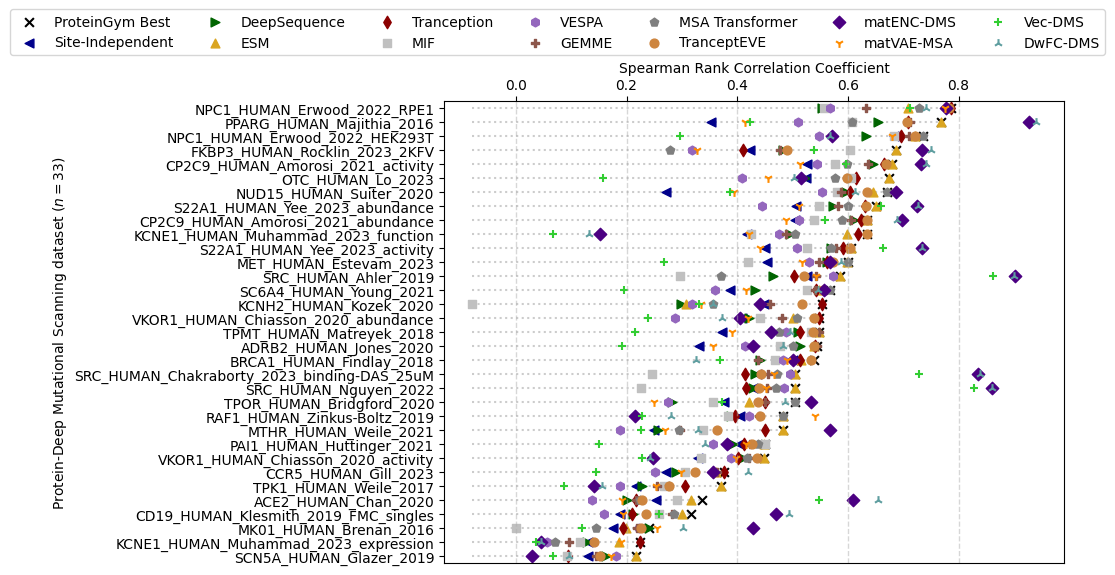

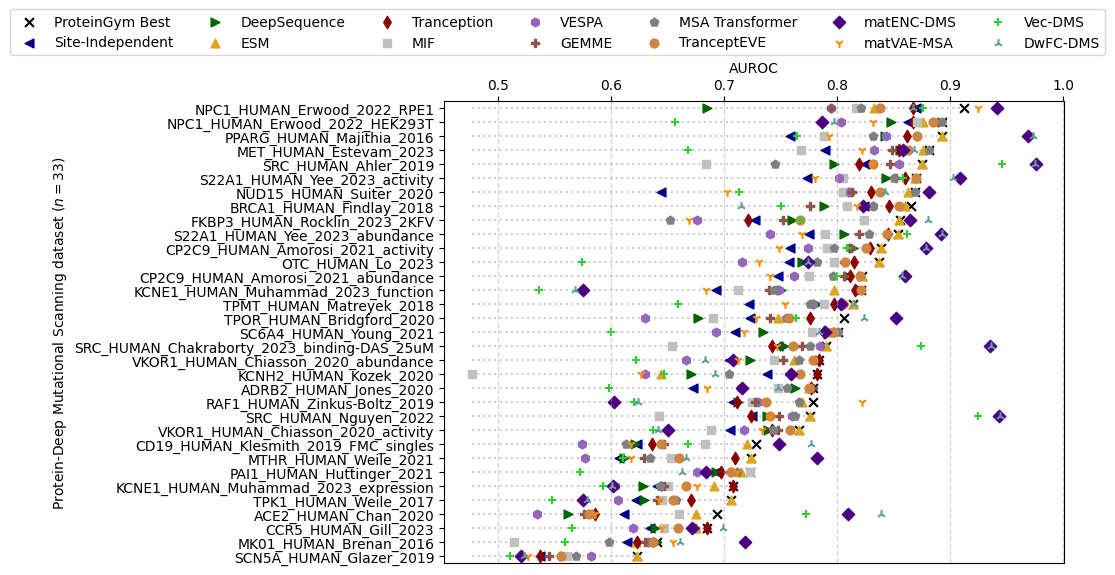

In [7]:
root_dir = "../lightning_logs_new"
save = True
# all_exp_name = ["indivSTRUCT"]#,"indivMOG1", , "indivVAMP100","indivVAMP10"]
# all_exp_name = ["indivSTRUCT" , "indivVAMP100","indivVAMP10", "indivVAMP150", "indivVAMP1", ]
# all_exp_name = ["indivVAMP1", "indivVAMP10", "indivVAMP100", "indivVAMP150"]
# all_exp_name = ["indivMOG1","indivMOG10","indivMOG100", "indivVAMP5", "indivVAMP150"]
# "indivMOG100","indivVAMP100",
Tables = {}
our_best = False
all_exp_name = ["matENCDMS" ] + ["matVAEMOG1", "VecDMS","DwFCDMS"]

ref_model = "Our best" if our_best else all_exp_name[0]
    
thesize = 40
subgroup = "all"

for thescore in ["spearmanr", "auroc"]:
    all_exp_name = ["matENCDMS" ] \
                + ["matVAEMOG1", "VecDMS","DwFCDMS"]# # "indivVAMP5",
    comparison_methods = ["Site-Independent","DeepSequence{}","ESM{}", 
                          "Tranception{}","MIF{}", "VESPA{}","GEMME", "MSA Transformer{}","TranceptEVE{}"]

    print(thescore)
    dfout, all_models, df_benchmark, dfours = read_benchmark(thescore, comparison_methods, all_exp_name, root_dir, our_best=our_best)
    dfout = pd.concat([dfout, groupnames], axis=1)
    
    dfout["matENC-DMS"] = dfout["matENCDMS"]#dfout[all_exp_name[:3]].max(1)
    all_exp_name = ["matENC-DMS" ] + ["matVAE-MSA"] + ["Vec-DMS"]+ ["DwFC-DMS"]
    
    dfout.rename(columns={"matVAEMOG1":"matVAE-MSA"},inplace=True)
    dfout.rename(columns={"VecDMS":"Vec-DMS"},inplace=True)
    dfout.rename(columns={"DwFCDMS":"DwFC-DMS"},inplace=True)
    
    plot_models = [s.replace("{}","") for s in comparison_methods]
    plot_models += (all_exp_name if not our_best else ["Our best"])
    
    if ref_model != "Our best":
        tmp = dfout[all_exp_name].dropna(how="all")
        print(tmp[tmp.isna().any(axis=1)])
    
    anyNAN = (dfout[plot_models].isna().sum(1) > 0).values
    dfout = dfout[~anyNAN]
    
    models_color = {k: v for k,v in zip(plot_models, possible_colors[:len(plot_models)])}
    models_markers = {k: v for k,v in zip(plot_models, possible_markers[:len(plot_models)])}

    dfout_subgroup = dfout
    
    outname_stem = "our_vs_other_models_{}".format(thescore)
    
    height = 6 * dfout_subgroup.shape[0] / dfout.shape[0]
    
    fig, ax = plot_against_benchmark(dfout_subgroup, plot_models, models_color, 
                                     models_markers, thesize, figsize=(8, height), 
                                     legend_loc=(-0.7, 1.1), prefix=subgroup if subgroup != "all" else "",thescore=thescore)
    
    if save:
        fig.savefig(outname_stem + ".pdf", dpi=300, bbox_inches="tight")
    
    all_compared_models = np.array(plot_models + ["Best Benchmark"])
    thetable = make_table(dfout_subgroup, all_compared_models, outname_stem, ref_model=None, prefix=thescore.capitalize(), save=save)
    Tables[thescore] = thetable

df_table = pd.concat([t.rename(columns={"Average Raw":s})[[s]] for s,t in Tables.items()],axis=1)
if save:
    df_table.to_latex("our_vs_other_models" + ".tex", float_format="%.3f")
df_table

spearmanr
Empty DataFrame
Columns: [matENC-DMS, matVAE-MSA, Vec-DMS, DwFC-DMS]
Index: []


,spearmanr
Spearmanr,
Best Benchmark,0.529 $\pm$ 0.151
matENC-DMS,0.522 $\pm$ 0.24
ESM,0.508 $\pm$ 0.157
DwFC-DMS,0.507 $\pm$ 0.242
TranceptEVE,0.485 $\pm$ 0.167
Tranception,0.478 $\pm$ 0.165
GEMME,0.461 $\pm$ 0.155
MSA Transformer,0.452 $\pm$ 0.167
DeepSequence,0.425 $\pm$ 0.151


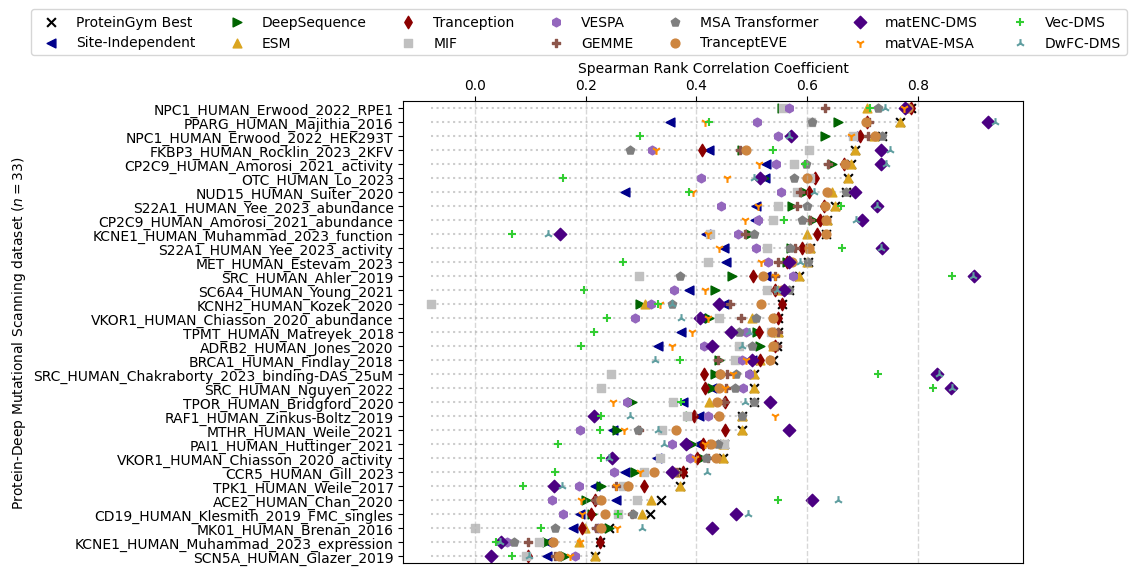

In [7]:
root_dir = "../lightning_logs_new"
save = False
# all_exp_name = ["indivSTRUCT"]#,"indivMOG1", , "indivVAMP100","indivVAMP10"]
# all_exp_name = ["indivSTRUCT" , "indivVAMP100","indivVAMP10", "indivVAMP150", "indivVAMP1", ]
# all_exp_name = ["indivVAMP1", "indivVAMP10", "indivVAMP100", "indivVAMP150"]
# all_exp_name = ["indivMOG1","indivMOG10","indivMOG100", "indivVAMP5", "indivVAMP150"]
# "indivMOG100","indivVAMP100",
Tables = {}
our_best = False
all_exp_name = ["matENCDMS" ] + ["matVAEMOG1", "VecDMS","DwFCDMS"]

ref_model = "Our best" if our_best else all_exp_name[0]
    
thesize = 40
subgroup = "all"

for thescore in ["spearmanr"]:
    all_exp_name = ["matENCDMS" ] \
                + ["matVAEMOG1", "VecDMS","DwFCDMS"]# # "indivVAMP5",
    comparison_methods = ["Site-Independent","DeepSequence{}","ESM{}", 
                          "Tranception{}","MIF{}", "VESPA{}","GEMME", "MSA Transformer{}","TranceptEVE{}"]

    print(thescore)
    dfout, all_models, df_benchmark, dfours = read_benchmark(thescore, comparison_methods, all_exp_name, root_dir, our_best=our_best)
    dfout = pd.concat([dfout, groupnames], axis=1)
    
    dfout["matENC-DMS"] = dfout["matENCDMS"]#dfout[all_exp_name[:3]].max(1)
    all_exp_name = ["matENC-DMS" ] + ["matVAE-MSA"] + ["Vec-DMS"]+ ["DwFC-DMS"]
    
    dfout.rename(columns={"matVAEMOG1":"matVAE-MSA"},inplace=True)
    dfout.rename(columns={"VecDMS":"Vec-DMS"},inplace=True)
    dfout.rename(columns={"DwFCDMS":"DwFC-DMS"},inplace=True)
    
    plot_models = [s.replace("{}","") for s in comparison_methods]
    plot_models += (all_exp_name if not our_best else ["Our best"])
    
    if ref_model != "Our best":
        tmp = dfout[all_exp_name].dropna(how="all")
        print(tmp[tmp.isna().any(axis=1)])
    
    anyNAN = (dfout[plot_models].isna().sum(1) > 0).values
    dfout = dfout[~anyNAN]
    
    models_color = {k: v for k,v in zip(plot_models, possible_colors[:len(plot_models)])}
    models_markers = {k: v for k,v in zip(plot_models, possible_markers[:len(plot_models)])}

    dfout_subgroup = dfout
    
    outname_stem = "our_vs_other_models_{}".format(thescore)
    
    height = 6 * dfout_subgroup.shape[0] / dfout.shape[0]
    
    fig, ax = plot_against_benchmark(dfout_subgroup, plot_models, models_color, 
                                     models_markers, thesize, figsize=(8, height), 
                                     legend_loc=(-0.6, 1.1), prefix=subgroup if subgroup != "all" else "",thescore=thescore)
    
    if save:
        fig.savefig(outname_stem + ".pdf", dpi=300, bbox_inches="tight")
    
    all_compared_models = np.array(plot_models + ["Best Benchmark"])
    thetable = make_table(dfout_subgroup, all_compared_models, outname_stem, ref_model=None, prefix=thescore.capitalize(), save=save)
    Tables[thescore] = thetable

df_table = pd.concat([t.rename(columns={"Average Raw":s})[[s]] for s,t in Tables.items()],axis=1)
if save:
    df_table.to_latex("our_vs_other_models" + ".tex", float_format="%.3f")
df_table

In [21]:
dfbest_msa = dfout[np.isin(dfout.index , ["RAF1_HUMAN_Zinkus-Boltz_2019","MK01_HUMAN_Brenan_2016"])][["matVAE-MSA","Best Benchmark"]]
dfbest_msa.index = [s.split("_")[0] for s in dfbest_msa.index]
dfbest_msa.columns = ["\\textbf{matVAE-MSA}" , "\\textbf{Best Benchmark}"]

dfbest_msa.to_latex("best_performing.tex", float_format="%.3f")

In [18]:
dfbest_msa

,Best Benchmark Name,matVAE-MSA,Best Benchmark
MK01,DeepSequence (ensemble),0.255798,0.241
RAF1,MSA Transformer (single),0.541351,0.482


In [7]:
df_benchmark.columns

Index(['Site-Independent', 'EVmutation', 'DeepSequence (single)',
       'DeepSequence (ensemble)', 'EVE (single)', 'EVE (ensemble)', 'Unirep',
       'Unirep evotuned', 'MSA Transformer (single)',
       'MSA Transformer (ensemble)', 'ESM-1b', 'ESM-1v (single)',
       'ESM-1v (ensemble)', 'ESM2 (8M)', 'ESM2 (35M)', 'ESM2 (150M)',
       'ESM2 (650M)', 'ESM2 (3B)', 'ESM2 (15B)', 'Wavenet', 'RITA S', 'RITA M',
       'RITA L', 'RITA XL', 'Progen2 S', 'Progen2 M', 'Progen2 Base',
       'Progen2 L', 'Progen2 XL', 'GEMME', 'VESPA', 'VESPAl', 'ProtGPT2',
       'Tranception S no retrieval', 'Tranception M no retrieval',
       'Tranception L no retrieval', 'Tranception S', 'Tranception M',
       'Tranception L', 'TranceptEVE S', 'TranceptEVE M', 'TranceptEVE L',
       'CARP (38M)', 'CARP (600K)', 'CARP (640M)', 'CARP (76M)', 'MIF',
       'MIF-ST', 'ESM-IF1', 'ProteinMPNN'],
      dtype='object')

## Best benchmark per protein DMS

In [8]:
all_exp_name = ["matENCDMS" ] + ["matVAEMOG1", "VecDMS","DwFCDMS"]

dfout, all_models, df_benchmark, dfours = read_benchmark("spearmanr", comparison_methods, all_exp_name, root_dir, our_best=our_best)
dfout = pd.concat([dfout, groupnames], axis=1)

dfout["matENC-DMS"] = dfout["matENCDMS"]#dfout[all_exp_name[:3]].max(1)
all_exp_name = ["matENC-DMS" ] + ["matVAE-MSA"] + ["Vec-DMS"]+ ["DwFC-DMS"]

dfout.rename(columns={"matVAEMOG1":"matVAE-MSA"},inplace=True)
dfout.rename(columns={"VecDMS":"Vec-DMS"},inplace=True)
dfout.rename(columns={"DwFCDMS":"DwFC-DMS"},inplace=True)

plot_models = [s.replace("{}","") for s in comparison_methods]
plot_models += (all_exp_name if not our_best else ["Our best"])

if ref_model != "Our best":
    tmp = dfout[all_exp_name].dropna(how="all")
    print(tmp[tmp.isna().any(axis=1)])

anyNAN = (dfout[plot_models].isna().sum(1) > 0).values
dfout = dfout[~anyNAN]

dfout.index.name = "DMS_id"
dfout["Model Family"] = dfout["Best Benchmark Name"].apply(lambda s: ("ESM" if ("ESM" in s) else s))\
.apply(lambda s: ("DeepSequence" if ("DeepSequence" in s) else s))\
.apply(lambda s: ("MIF" if ("MIF" in s) else s))\
.apply(lambda s: ("MSA Transformer" if ("MSA Transformer" in s) else s))\
.apply(lambda s: ("Tranception" if ("Tranception" in s) else s))\
.apply(lambda s: ("TranceptEVE" if ("TranceptEVE" in s) else s))
dfout[["Best Benchmark Name"]].to_csv("best_benchmark_name.csv")#.unique()
#dfout["Best Benchmark Family"].to_csv("best_benchmark_family.csv")#.unique()
counts = dfout[["Model Family"]].value_counts()#.to_csv("best_benchmark_name.csv")
dfout["Model Family"] = dfout["Model Family"].apply(lambda s: "{} (n={})".format(s,counts[(s,)]))
counts = dfout[["Best Benchmark Name"]].value_counts()#.to_csv("best_benchmark_name.csv")
dfout["Best Benchmark Name"] = dfout["Best Benchmark Name"].apply(lambda s: "{} x{}".format(s,counts[(s,)]))

df_model_family = dfout[["Best Benchmark Name", "Model Family"]].reset_index(drop=True).groupby("Model Family").apply(lambda s:s).drop(columns=["Model Family"]).droplevel(-1).drop_duplicates()
if save:
    df_model_family['indexNumber'] = list(map(lambda s: parse("{}(n={:d})",s)[1], df_model_family.index.values))#.str.rsplit('=').str[:-1].astype(int)
    df_model_family = df_model_family.sort_values(['indexNumber'],ascending=False).drop('indexNumber', axis=1)
    df_model_family.to_latex("best_model_family.tex", multirow=False)
df_model_family

Empty DataFrame
Columns: [matENC-DMS, matVAE-MSA, Vec-DMS, DwFC-DMS]
Index: []


,Best Benchmark Name
Model Family,
ESM (n=15),ESM2 (15B) x2
ESM (n=15),ESM-1v (ensemble) x7
ESM (n=15),ESM2 (150M) x2
ESM (n=15),ESM2 (650M) x1
ESM (n=15),ESM-IF1 x2
ESM (n=15),ESM-1v (single) x1
MSA Transformer (n=6),MSA Transformer (single) x2
MSA Transformer (n=6),MSA Transformer (ensemble) x4
Tranception (n=5),Tranception L x2


In [9]:
parse("{}(n={:d})",df_model_family.index.values[0])

<Result ('ESM ', 15) {}>

# Plots per protein DMS

In [15]:
root_dir = "../lightning_logs_new"
all_exp_name = ["matENCDMS" ] + ["matVAEMOG1", "VecDMS"]
thescore = "spearmanr"
comparison_methods = ["TranceptEVE", "GEMME"]   ###'GEMME', 'Tranception', 'TranceptEVE', 'Site-Independent','EVmutation',

dfout, all_models, df_benchmark, dfours= read_benchmark(thescore, comparison_methods, all_exp_name, root_dir, our_best=False)

dfout = pd.concat([dfout, groupnames], axis=1)
dfout["matENC-DMS"] = dfout["matENCDMS"]#dfout[all_exp_name[:3]].max(1)
dfout["rel_increase_best_model"] = (dfout["matENC-DMS"] - dfout["Best Benchmark"]) / dfout["Best Benchmark"]
dfout["rel_increase_msa"] = (dfout["matENC-DMS"] - dfout["matVAEMOG1"]) / dfout["matVAEMOG1"]
dfout["rel_increase_enc"] = (dfout["matENC-DMS"] - dfout["VecDMS"]) / dfout["VecDMS"]

D = []
compare_models = comparison_methods + ["Best Benchmark", "minEVE"]
compare_models = ["Best Benchmark", "minEVE"]
compare_models = ["Best Benchmark", "TranceptEVE", "minEVE"]
compare_models = ["matENC-DMS","Best Benchmark"]

for modelname in compare_models:
    dmodel = dfout[[modelname, "rel_increase_best_model", "rel_increase_msa","rel_increase_enc"] + extra_cols].copy()
    
    dmodel["modelname"] = modelname
    dmodel.reset_index(inplace=True)
    dmodel.rename(columns={modelname: "Score"}, inplace=True)
    D.append(dmodel)

Dconcat = pd.concat(D)
Dconcat = Dconcat[~np.isin(Dconcat["annotation"],["other human","Virus","Prokaryote","Eukaryote"])]

figsize = {"height": 250, "width": 600}
Dconcat["coarse_selection_type"].replace({"OrganismalFitness": "Organism Fitness"},inplace=True)
Dconcat["annotation"].replace({"drug target": "Drug target"},inplace=True)

for xname in ["coarse_selection_type","annotation"]:
    fig = px.box(Dconcat[Dconcat["modelname"]=="matENC-DMS"], x=[xname], y="rel_increase_best_model", 
               color="modelname", template="none", points="all", hover_data=["Score", "index"], color_discrete_sequence=["black","darkred"]
                )
    
    fig.update_layout(
        title="",
        xaxis_title="",showlegend=False,
        yaxis_title="Relative increase<br>from Best Benchmark",**figsize,font=dict(size=14),
        margin=dict(t=0,r=0,b=20,l=70)
    )
    fig.update_yaxes(range=[-1.1, 1.12], autorange=False)
    #fig.show()
    if save:
        fig.write_image("relative_increase_best_model_per_{}.pdf".format(xname))
    fig.show()
    
    fig = px.box(Dconcat[Dconcat["modelname"]=="matENC-DMS"], x=[xname], y="rel_increase_enc", 
               color="modelname", template="none", points="all", hover_data=["Score", "index"], color_discrete_sequence=["black","darkred"]
                )
    
    fig.update_layout(
        title="",
        xaxis_title="",showlegend=False,
        yaxis_title="Relative increase<br>from VecENC",**figsize,font=dict(size=14),
        margin=dict(t=0,r=0,b=20,l=70)
    )
    #fig.update_yaxes(range=[-1.1, 1.12], autorange=False)
    
    if save:
        fig.write_image("relative_increase_enc_per_{}.pdf".format(xname))
    fig.show()
    
    fig = px.box(Dconcat, x=[xname], y="Score", 
                   color="modelname", template="none", points="all",
                hover_data=["Score", "index"], color_discrete_sequence=["black","darkred"],
                 labels={'modelname': 'Model'}
                )
    fig.update_layout(
        title="",
        xaxis_title="",
        yaxis_title="Spearmanr",**figsize,font=dict(size=14),margin=dict(t=0,r=0,b=20,l=50),
         legend=dict(yanchor="top",y=1,xanchor="left",x=0.2,orientation="h",borderwidth=1)
    )
    fig.update_yaxes(range=[0, 1.1], autorange=False)
    fig.update_xaxes(tickangle=0)

    
    if save:
        fig.write_image("indivlatenttodms_per_{}.pdf".format(xname))
    fig.show()
    fig = px.box(Dconcat[Dconcat["modelname"]=="matENC-DMS"], x=[xname], y="rel_increase_msa", 
               color="modelname", template="none", points="all", hover_data=["Score", "index"], color_discrete_sequence=["black"]
                )
    
    fig.update_layout(
        title="",
        xaxis_title="",showlegend=False,
        yaxis_title="Relative increase<br>from MSA",**figsize,font=dict(size=14),margin=dict(t=0,r=0,b=20,l=70)
    )
    #fig.update_yaxes(range=[-1, 1.65], autorange=False)
    fig.show()
    if save:
        fig.write_image("relative_increase_MSA_per_{}.pdf".format(xname))
    fig.show()

In [11]:
labels = {"Expected_SNVs": "Expected SNVs", 
          "Observed_SNVs":"Observed SNVs", 
          "pLI": "Probability of Loss of Function Intolerance", 
          "oe":"Observed/Expected", "MSA_num_seqs":"MSA Num Seqs"}
dplot = Dconcat[Dconcat["modelname"]=="matENC-DMS"]
all_cols = ["Expected_SNVs",	"Observed_SNVs", "pLI", "oe", "MSA_num_seqs"]
save=True
for col in all_cols:
    
    ### dplot=dplot[dplot["Expected SNVs"]<75]
    fig = px.scatter(dplot, x=[col], y="rel_increase_msa", # color="annotation",
                 hover_data=["Score", "index"], color_discrete_sequence=["black","darkred","darkblue","darkgreen"], #color="modelname",
                trendline="ols",template="none", labels=labels)
        
    # retrieve model estimates
    model = px.get_trendline_results(fig)
    results = model.iloc[0]["px_fit_results"]
    alpha = results.params[0]
    beta = results.params[1]
    p_beta = results.pvalues[1]
    r_squared = results.rsquared
    
    line1 = 'y = ' + str(round(alpha, 4)) + ' + ' + str(round(beta, 4))+'x'
    line2 = 'p-value = ' + '{:.5f}'.format(p_beta)
    line3 = 'R^2 = ' + str(round(r_squared, 3))
    #summary = line1 + '; ' + 
    summary = line2 + '; ' + line3
    #print(summary)
    fig.update_layout(
        title=dict(text=summary, font=dict(size=14)),#, automargin=True
        xaxis_title=labels[col],showlegend=False,
        legend=dict(yanchor="top",y=1.25,xanchor="left",x=0.05,orientation="h",borderwidth=1),
        yaxis_title="Relative increase<br>from MSA",**{"height": 250, "width": 500},font=dict(size=14),margin=dict(t=30,r=0,b=50,l=70),
    )
    fig.update_yaxes(range=[-1, 1.65], autorange=False)
    
    if save:
        fig.write_image("relative_increase_MSA_vs_{}.pdf".format(col.replace(" ","-")))##.replace("(",
    fig.show()

# Prior

In [52]:
root_dir = "../lightning_logs_new"
# all_exp_name = ["indivSTRUCT"]#,"indivMOG1", , "indivVAMP100","indivVAMP10"]
# all_exp_name = ["indivSTRUCT" , "indivVAMP100","indivVAMP10", "indivVAMP150", "indivVAMP1", ]
# all_exp_name = ["indivVAMP1", "indivVAMP10", "indivVAMP100", "indivVAMP150"]
# all_exp_name = ["indivMOG1","indivMOG10","indivMOG100", "indivVAMP5", "indivVAMP150"]
# "indivMOG100","indivVAMP100",
Tables={}
our_best = False
all_exp_name = ["matVAEMOG1","matVAEMOG5","matVAEMOG10","matVAEMOG100"] + ["matVAEVAMP5","matVAEVAMP10","matVAEVAMP100"]

ref_model = "Our best" if our_best else all_exp_name[0]
    
thesize = 40
subgroup = "all"

for thescore in ["spearmanr", "auroc"]:
    #all_exp_name = ["matENCDMS" ] \
    #            + ["matVAEMOG1", "VecDMS","DwFCDMS"]# # "indivVAMP5",
    #comparison_methods = ["DeepSequence{}","ESM{}", "Tranception{}","MIF{}", "VESPA{}"]#,"GEMME","MSA Transformer{}","TranceptEVE{}"]
    comparison_methods = ["Site-Independent","DeepSequence{}","ESM{}", 
                          "Tranception{}","MIF{}", "VESPA{}","GEMME", "MSA Transformer{}","TranceptEVE{}"]
    print(thescore)
    dfout, all_models, df_benchmark, dfours = read_benchmark(thescore, comparison_methods, all_exp_name, root_dir, our_best=our_best)
    dfout = pd.concat([dfout, groupnames], axis=1)
    
    #dfout["matENC-DMS"] = dfout["matENCDMS"]#dfout[all_exp_name[:3]].max(1)
    #all_exp_name = ["matENC-DMS" ] + ["matVAE-MSA"] + ["Vec-DMS"]+ ["DwFC-DMS"]
    
    #dfout.rename(columns={"matVAEMOG1":"matVAE-MSA"},inplace=True)
    dfout.rename(columns={"VecDMS":"Vec-DMS"},inplace=True)
    dfout.rename(columns={"DwFCDMS":"DwFC-DMS"},inplace=True)
    
    plot_models = [s.replace("{}","") for s in comparison_methods]
    plot_models += (all_exp_name if not our_best else ["Our best"])
    
    if ref_model != "Our best":
        tmp = dfout[all_exp_name].dropna(how="all")
        print(tmp[tmp.isna().any(axis=1)])
    
    anyNAN = (dfout[plot_models].isna().sum(1) > 0).values
    dfout = dfout[~anyNAN]
    
    #models_color = {k: v for k,v in zip(plot_models, possible_colors[:len(plot_models)])}
    #models_markers = {k: v for k,v in zip(plot_models, possible_markers[:len(plot_models)])}

    dfout_subgroup = dfout
    
    outname_stem = "our_vs_other_models_{}_priors".format(thescore)
    
    #height = 6 * dfout_subgroup.shape[0] / dfout.shape[0]
    
    #fig, ax = plot_against_benchmark(dfout_subgroup, plot_models, models_color, 
    #                                 models_markers, thesize, figsize=(8, height), 
    #                                 legend_loc=(-0.6, 1.1), prefix=subgroup if subgroup != "all" else "",thescore=thescore)
    
    #if save:
    #    fig.savefig(outname_stem + ".pdf", dpi=300, bbox_inches="tight")
    
    all_compared_models = np.array(plot_models + ["Best Benchmark"])
    thetable = make_table(dfout_subgroup, all_compared_models, outname_stem, ref_model=None, prefix=thescore.capitalize(), save=save)
    Tables[thescore] = thetable

df_table = pd.concat([t.rename(columns={"Average Raw":s})[[s]] for s,t in Tables.items()],axis=1)
df_table.index = [s.replace("matVAE",  "") for s in df_table.index]

if save:
    df_table.to_latex("our_vs_other_models_priors.tex", float_format="%.3f")
df_table

spearmanr
Empty DataFrame
Columns: [matVAEMOG1, matVAEMOG5, matVAEMOG10, matVAEMOG100, matVAEVAMP5, matVAEVAMP10, matVAEVAMP100]
Index: []
auroc
Empty DataFrame
Columns: [matVAEMOG1, matVAEMOG5, matVAEMOG10, matVAEMOG100, matVAEVAMP5, matVAEVAMP10, matVAEVAMP100]
Index: []


,spearmanr,auroc
Best Benchmark,0.529 $\pm$ 0.151,0.794 $\pm$ 0.076
ESM,0.508 $\pm$ 0.157,0.78 $\pm$ 0.079
TranceptEVE,0.485 $\pm$ 0.167,0.763 $\pm$ 0.088
Tranception,0.478 $\pm$ 0.165,0.761 $\pm$ 0.086
GEMME,0.461 $\pm$ 0.155,0.75 $\pm$ 0.085
MSA Transformer,0.452 $\pm$ 0.167,0.746 $\pm$ 0.089
DeepSequence,0.425 $\pm$ 0.151,0.729 $\pm$ 0.084
MOG1,0.401 $\pm$ 0.138,0.721 $\pm$ 0.083
MOG10,0.4 $\pm$ 0.136,0.721 $\pm$ 0.084
VAMP100,0.399 $\pm$ 0.137,0.72 $\pm$ 0.082


In [25]:
root_dir = "../lightning_logs_new"
all_exp_name = ["matVAEMOG1","matVAEMOG5","matVAEMOG10","matVAEMOG100"] + ["matVAEVAMP5","matVAEVAMP10","matVAEVAMP100"]

#all_exp_name = ["matENCDMS" ] + ["matVAEMOG1", "VecDMS"]

thescore = "spearmanr"
comparison_methods = ["TranceptEVE", "GEMME"]   ###'GEMME', 'Tranception', 'TranceptEVE', 'Site-Independent','EVmutation',

dfout, all_models, df_benchmark, dfours= read_benchmark(thescore, comparison_methods, all_exp_name, root_dir, our_best=False)

dfout = pd.concat([dfout, groupnames], axis=1)
#dfout["matENC-DMS"] = dfout["matENCDMS"]#dfout[all_exp_name[:3]].max(1)
dfout["MOG1"] = (dfout["matVAEMOG1"] - dfout["matVAEMOG1"]) / dfout["matVAEMOG1"]
dfout["MOG5"] = (dfout["matVAEMOG5"] - dfout["matVAEMOG1"]) / dfout["matVAEMOG1"]
dfout["MOG10"] = (dfout["matVAEMOG10"] - dfout["matVAEMOG1"]) / dfout["matVAEMOG1"]
dfout["MOG100"] = (dfout["matVAEMOG100"] - dfout["matVAEMOG1"]) / dfout["matVAEMOG1"]
dfout["VAMP5"] = (dfout["matVAEVAMP5"] - dfout["matVAEMOG1"]) / dfout["matVAEMOG1"]
dfout["VAMP10"] = (dfout["matVAEVAMP10"] - dfout["matVAEMOG1"]) / dfout["matVAEMOG1"]
dfout["VAMP100"] = (dfout["matVAEVAMP100"] - dfout["matVAEMOG1"]) / dfout["matVAEMOG1"]

D = []
compare_models = comparison_methods + ["Best Benchmark", "minEVE"]
compare_models = ["Best Benchmark", "minEVE"]
compare_models = ["Best Benchmark", "TranceptEVE"]

#compare_models = ["MOG5","MOG10","MOG100"]

for modelname in compare_models:
    dmodel = dfout[[modelname, "MOG5", "MOG10","MOG100","VAMP5","VAMP10","VAMP100"] + extra_cols].copy()
    
    dmodel["modelname"] = modelname
    dmodel.reset_index(inplace=True)
    dmodel.rename(columns={modelname: "Score"}, inplace=True)
    D.append(dmodel)

Dconcat = pd.concat(D)
Dconcat = Dconcat[~np.isin(Dconcat["annotation"],["other human","Virus","Prokaryote","Eukaryote"])]


In [36]:

figsize = {"height": 250, "width": 600}
save=True
fig = px.box(dfout.reset_index(),y=["MOG1","MOG5","MOG10","MOG100","VAMP5","VAMP10","VAMP100"],#color="modelname", 
             template="none", points="all", color_discrete_sequence=["black","darkred"],hover_data=["index"]
            )

fig.update_layout(
    title="",
    xaxis_title="", showlegend=False,
    yaxis_title="Relative increase<br>from MOG1",**figsize,font=dict(size=14),
    margin=dict(t=0,r=0,b=20,l=75)
)
tickvals=[-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4]
fig.update_yaxes(tickmode = 'array',tickvals=tickvals,ticktext=list(map(str,tickvals)))
#range=[-0.35,0.35]
if save:
    fig.write_image("rel_increase_mog1_prior.pdf")
fig.show()
labels = {k:k.replace("matVAE","") for k in ["matVAEMOG1","matVAEMOG5","matVAEMOG10","matVAEMOG100","matVAEVAMP5","matVAEVAMP10","matVAEVAMP100"]}
fig = px.box(dfout[["matVAEMOG1","matVAEMOG5","matVAEMOG10","matVAEMOG100","matVAEVAMP5","matVAEVAMP10","matVAEVAMP100"]],#,x=,#color="modelname", 
             template="none", points="all", color_discrete_sequence=["black","darkred"],labels=labels, 
            )

fig.update_layout(
    title="",
    xaxis_title="", showlegend=False,
    yaxis_title="Raw SpearmanR",**figsize,font=dict(size=14),
    margin=dict(t=0,r=0,b=20,l=75)
)
fig.update_xaxes(tickangle=0,labelalias=labels)
fig.update_yaxes(range=[0,1.1])
fig.show()
if save:
    fig.write_image("raw_spearman_prior.pdf")


In [17]:
dfout

Index(['A0A1I9GEU1_NEIME_Kennouche_2019', 'CAS9_STRP1_Spencer_2017_positive',
       'ENVZ_ECOLI_Ghose_2023', 'SCN5A_HUMAN_Glazer_2019',
       'KCNE1_HUMAN_Muhammad_2023_expression', 'MK01_HUMAN_Brenan_2016',
       'SYUA_HUMAN_Newberry_2020', 'SPG1_STRSG_Wu_2016',
       'TADBP_HUMAN_Bolognesi_2019', 'CALM1_HUMAN_Weile_2017',
       ...
       'TCRG1_MOUSE_Rocklin_2023_1E0L', 'NPC1_HUMAN_Erwood_2022_RPE1',
       'RPC1_BP434_Rocklin_2023_1R69', 'RL20_AQUAE_Rocklin_2023_1GYZ',
       'OBSCN_HUMAN_Rocklin_2023_1V1C', 'CBPA2_HUMAN_Rocklin_2023_1O6X',
       'PR40A_HUMAN_Rocklin_2023_1UZC', 'PHOT_CHLRE_Chen_2023',
       'DNJA1_HUMAN_Rocklin_2023_2LO1', 'EPHB2_HUMAN_Rocklin_2023_1F0M'],
      dtype='object', length=217)

In [51]:
dftable = dfout[["MOG5","MOG10","MOG100","VAMP5","VAMP10","VAMP100"]].dropna()
dftable = (100*dftable.loc[["TPOR_HUMAN_Bridgford_2020",'SCN5A_HUMAN_Glazer_2019']].round(3))
dftable.index = [s.split("_")[0] for s in dftable.index]
dftable.to_latex("increase_in_spearmanR_prior.tex", float_format="%.1f",column_format="p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}p{1cm}")


In [35]:
list(map(lambda s: s, dftable.index))
['KCNE1_HUMAN_Muhammad_2023_expression','TPOR_HUMAN_Bridgford_2020'

['SCN5A_HUMAN_Glazer_2019',
 'KCNE1_HUMAN_Muhammad_2023_expression',
 'MK01_HUMAN_Brenan_2016',
 'CD19_HUMAN_Klesmith_2019_FMC_singles',
 'ACE2_HUMAN_Chan_2020',
 'TPK1_HUMAN_Weile_2017',
 'CCR5_HUMAN_Gill_2023',
 'VKOR1_HUMAN_Chiasson_2020_activity',
 'PAI1_HUMAN_Huttinger_2021',
 'MTHR_HUMAN_Weile_2021',
 'RAF1_HUMAN_Zinkus-Boltz_2019',
 'TPOR_HUMAN_Bridgford_2020',
 'SRC_HUMAN_Nguyen_2022',
 'SRC_HUMAN_Chakraborty_2023_binding-DAS_25uM',
 'BRCA1_HUMAN_Findlay_2018',
 'ADRB2_HUMAN_Jones_2020',
 'TPMT_HUMAN_Matreyek_2018',
 'VKOR1_HUMAN_Chiasson_2020_abundance',
 'KCNH2_HUMAN_Kozek_2020',
 'SC6A4_HUMAN_Young_2021',
 'SRC_HUMAN_Ahler_2019',
 'MET_HUMAN_Estevam_2023',
 'S22A1_HUMAN_Yee_2023_activity',
 'KCNE1_HUMAN_Muhammad_2023_function',
 'CP2C9_HUMAN_Amorosi_2021_abundance',
 'S22A1_HUMAN_Yee_2023_abundance',
 'NUD15_HUMAN_Suiter_2020',
 'OTC_HUMAN_Lo_2023',
 'CP2C9_HUMAN_Amorosi_2021_activity',
 'FKBP3_HUMAN_Rocklin_2023_2KFV',
 'NPC1_HUMAN_Erwood_2022_HEK293T',
 'PPARG_HUMAN_Majith